# Sam2FCN

This is the very first Expermient for Building the Repository based on real Scenario.

## GOALS

The Goal of this experiment is to create a first working pipeline structure, aswell as implementing sam2FCN.

Goals to achieve:

- [ ] Create Minimal MVP of the Experiment.
- [ ] Create Builder and Sequence Based Architecture.
- [ ] Implement the minimal MVP in config form to Build the Pipeline and execute.

# MVP Experiment with Mars Image

In [2]:
import xml.etree.ElementTree as ET
from dataclasses import dataclass, field
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.patches import Rectangle
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry

In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x["area"]), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]["segmentation"].shape[0], sorted_anns[0]["segmentation"].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann["segmentation"]
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [4]:
def show_bboxes(bboxes):
    if len(bboxes) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)

    for bbox in bboxes:
        xmin, ymin, xmax, ymax, class_label = bbox

        # Draw rectangle
        width = xmax - xmin
        height = ymax - ymin
        rect = Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)

        # Add class label
        ax.text(
            xmin,
            ymin - 5,
            class_label,
            color="red",
            fontsize=12,
            weight="bold",
            bbox={"facecolor": "white", "alpha": 0.7, "edgecolor": "none"},
        )

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2))

In [6]:
@dataclass
class BndBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    def to_tensor(self, device=None) -> torch.Tensor:
        """
        Converts the bounding box to a PyTorch tensor.
        Returns:
            torch.Tensor: A tensor of shape (4,) representing [xmin, ymin, xmax, ymax].
        """
        if device:
            return torch.as_tensor([self.xmin, self.ymin, self.xmax, self.ymax], dtype=torch.int64, device=device)
        return torch.as_tensor([self.xmin, self.ymin, self.xmax, self.ymax], dtype=torch.int64)


@dataclass
class ObjectAnnotation:
    name: str
    pose: str
    truncated: int
    difficult: int
    bndbox: BndBox


@dataclass
class ImageAnnotation:
    folder: str
    filename: str
    width: int
    height: int
    depth: int
    objects: list[ObjectAnnotation] = field(default_factory=list)

In [7]:
def parse_voc_xml(xml_file: Path) -> ImageAnnotation:
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Type safety: Check for None explicitly and provide fallbacks
    folder = root.findtext("folder") or ""
    filename = root.findtext("filename") or ""

    # Ensure 'size' exists
    size = root.find("size")
    if size is None:
        raise ValueError("Missing <size> element in the XML file.")

    # Extract size details safely
    width = int(size.findtext("width") or 0)
    height = int(size.findtext("height") or 0)
    depth = int(size.findtext("depth") or 0)

    # Parse objects safely
    objects = []
    for obj in root.findall("object"):
        name = obj.findtext("name") or ""
        pose = obj.findtext("pose") or "Unspecified"
        truncated = int(obj.findtext("truncated") or 0)
        difficult = int(obj.findtext("difficult") or 0)

        bndbox = obj.find("bndbox")
        if bndbox is None:
            raise ValueError("Missing <bndbox> element for an object in the XML file.")

        bbox = BndBox(
            xmin=int(bndbox.findtext("xmin") or 0),
            ymin=int(bndbox.findtext("ymin") or 0),
            xmax=int(bndbox.findtext("xmax") or 0),
            ymax=int(bndbox.findtext("ymax") or 0),
        )
        objects.append(ObjectAnnotation(name, pose, truncated, difficult, bbox))

    return ImageAnnotation(folder, filename, width, height, depth, objects)

In [17]:
def merge_masks_with_priority(stacked_masks):
    """
    Merge stacked binary masks where higher indices have priority

    Args:
        stacked_masks (torch.Tensor): Shape (N, H, W) where N is number of masks

    Returns:
        torch.Tensor: Shape (H, W) merged mask
    """
    result = torch.zeros_like(stacked_masks[0])
    for mask in stacked_masks:
        result[mask > 0] = mask[mask > 0]
    return result

In [8]:
data_file = "RLB_581357762EDR_F0701752RHAZ00337M1"
image = cv2.imread(f"../data/datasets/mars/Images/{data_file}.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
annotation_file = f"../data/datasets/mars/Annotations/{data_file}.xml"
annotations = parse_voc_xml(annotation_file)

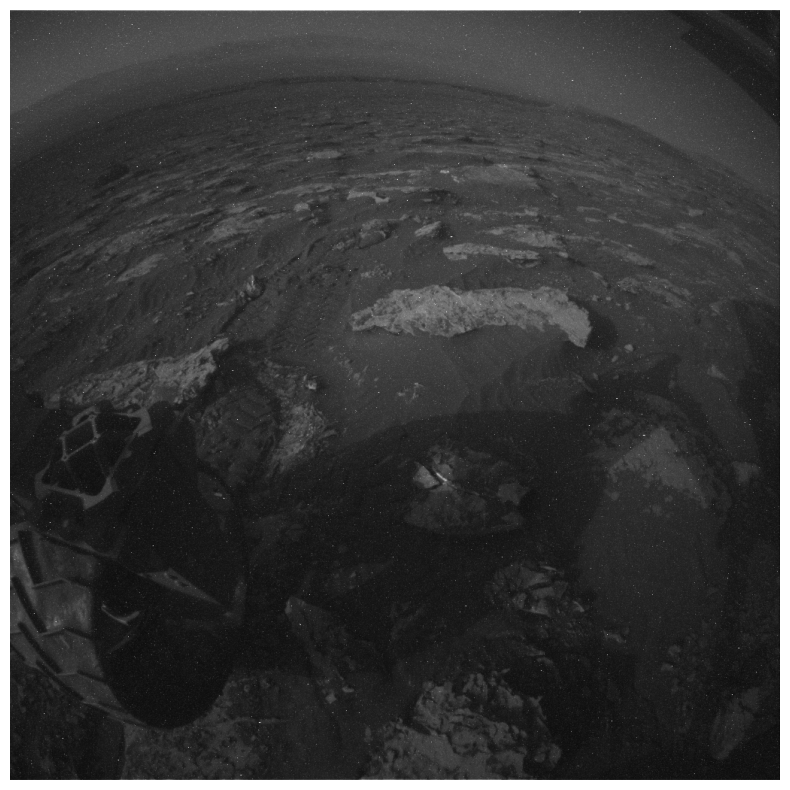

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

In [10]:
sam_checkpoint = "../data/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/home/matti/GIT/PytorchImagePipeline/.venv/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.l

In [ ]:
masks = mask_generator.generate(image)

We now need the additional BBoxes from the pascalvoc annotation.

In [11]:
bboxes = []
for obj in annotations.objects:
    bboxes.append([obj.bndbox.xmin, obj.bndbox.ymin, obj.bndbox.xmax, obj.bndbox.ymax, obj.name])

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks)
show_bboxes(bboxes)
plt.axis("off")
plt.show()

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks)
show_bboxes(bboxes)
plt.axis("off")
plt.show()

With this Hole Image Classification we could start and give the segments labels from the Bounding Boxes.

We have following Ideas in mind:

```
For Each BBox
    For Each Segment:
        IOU(Bbox, Segment)
        VerticalDist(UpperPixel(Segment), BBox)
        VerticalDist(LowerPixel(Segment), BBox)
        HorizontalDist(LeftPixel(Segment), BBox)
        HorizontalDist(RightPixel(Segment), BBox)
    SelectSegementWithBestMetrics()
```

Additional we could do something similiar From the Demo.
Since we already have BBoxes, we could use the BBoxes to create ROI which we use to calculate one segment with for this ROI.

Looking into that, it sounds very Promising. I ferify the workflow, they showed for multiple bboxes, with the Predictor class.

### Batched Prompt Input

In [ ]:
predictor = SamPredictor(sam)
predictor.set_image(image)

In [ ]:
input_boxes = torch.stack([obj.bndbox.to_tensor(device=predictor.device) for obj in annotations.objects])
input_classes = [obj.name for obj in annotations.objects]

In [ ]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [ ]:
masks.shape

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis("off")
plt.show()

### Batch Prompt over all images

In [ ]:
predictor = SamPredictor(sam)

dataset_location = Path("../data/datasets/mars/")

dataset_location / "Images"

total_iterations = len(list((dataset_location / "Images").glob("*.png")))

# Calculate subplot grid dimensions
rows = int(np.ceil(np.sqrt(total_iterations)))
cols = int(np.ceil(total_iterations / rows))

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(10 * cols, 10 * rows))
axes = axes.ravel()  # Flatten to 1D array for easy indexing

for idx, image_file in enumerate((dataset_location / "Images").glob("*.png")):
    ax = axes[idx]
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    try:
        annotations = parse_voc_xml(dataset_location / f"Annotations/{image_file.stem}.xml")
    except FileNotFoundError:
        print(f"No Annotations found for {image_file.stem}")
        ax.axis("off")
        continue
    predictor.set_image(image)

    input_boxes = torch.stack([obj.bndbox.to_tensor(device=predictor.device) for obj in annotations.objects])
    input_classes = [obj.name for obj in annotations.objects]

    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )

    ax.imshow(image)

    ax.imshow(image)
    for mask in masks:
        show_mask(mask.cpu().numpy(), ax, random_color=True)
    for box in input_boxes:
        show_box(box.cpu().numpy(), ax)
    ax.axis("off")

# Hide any unused subplots
for j in range(total_iterations, rows * cols):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

Okay now with all 100 first labeled Images of the mars data, we can See some promising results.
NOw lets ivenstigate one Image and get the combined masks.

In [12]:
data_file = "RLB_581357762EDR_F0701752RHAZ00337M1"
image = cv2.imread(f"../data/datasets/mars/Images/{data_file}.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor = SamPredictor(sam)
predictor.set_image(image)

input_boxes = torch.stack([obj.bndbox.to_tensor(device=predictor.device) for obj in annotations.objects])
input_classes = [obj.name for obj in annotations.objects]

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

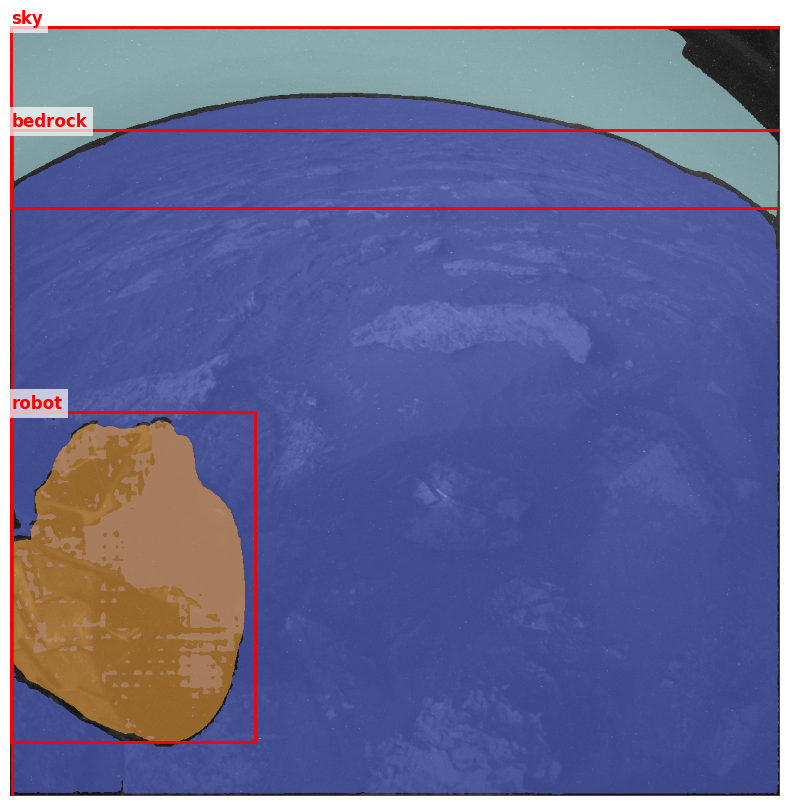

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
show_bboxes(bboxes)
plt.axis("off")
plt.show()

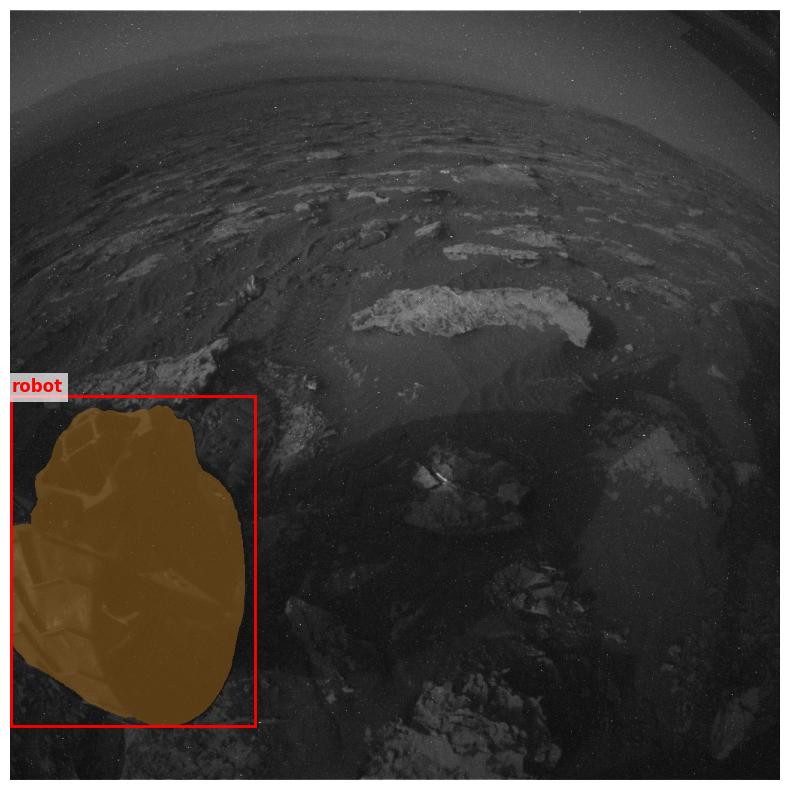

In [16]:
idx = 2

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[idx].cpu().numpy(), plt.gca(), random_color=True)
show_bboxes([
    bboxes[idx],
])
plt.axis("off")
plt.show()

In [36]:
classes_as_idx = {"bg": 0, "sky": 1, "bedrock": 2, "robot": 6}

classes_of_masks = torch.tensor([classes_as_idx[obj.name] for obj in annotations.objects])

t = masks.clone()
r = t * classes_of_masks.unsqueeze(1).unsqueeze(1).unsqueeze(1).to("cuda:0")
r[2].max()

tensor(6, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.9214517437682987].


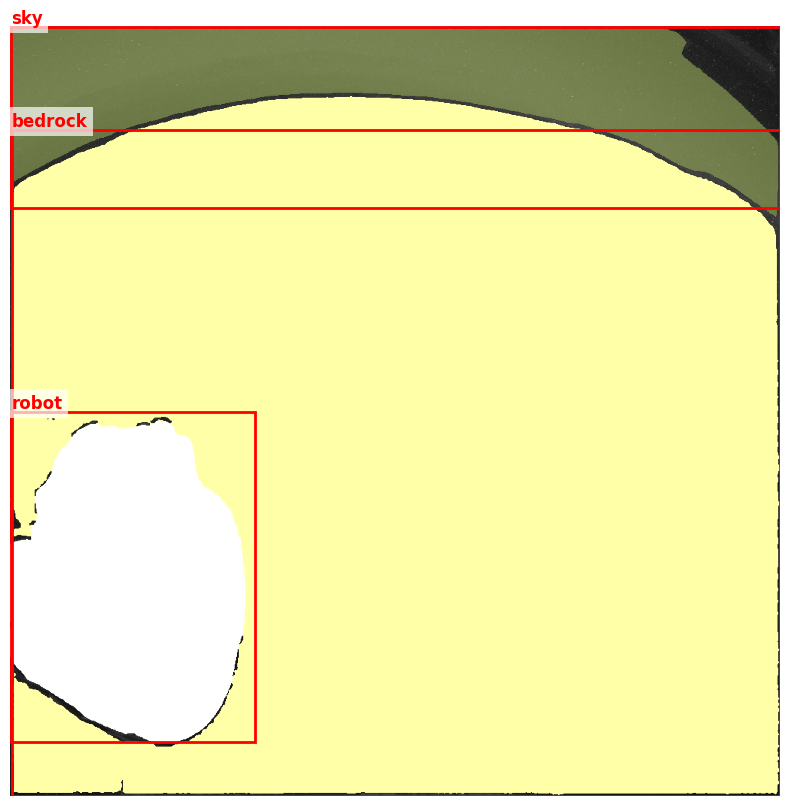

In [37]:
classed_masks = masks * classes_of_masks.unsqueeze(1).unsqueeze(1).unsqueeze(1).to("cuda:0")
combined_masks = merge_masks_with_priority(classed_masks)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(combined_masks.cpu().numpy(), plt.gca(), random_color=True)
show_bboxes(bboxes)
plt.axis("off")
plt.show()